In this notebook I did an extended classification on a dataset of English Twitter messages with six basic emotions: anger, fear, joy, love, sadness, and surprise.

In [51]:
#Punctuation was already removed. Dataset was devided into 3 separate csv files. Test.csv - 15%, train.csv - 70%, validation.csv-15.
#The validation.csv file is used during model training to monitor the model's performance across iterations. 
#It ensures the model generalizes well and avoids overfitting by giving
#feedback on how the model performs on unseen data during the training process.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string

test = pd.read_csv('test.csv')
train = pd.read_csv('training.csv')
validation = pd.read_csv('validation.csv')

#In csv files emotions are labeled with intigers from 0 to 5 where each lable describe specific emotion. 
#I added description column that maps each label to its representative name to visualise how dataset
#looks.
labels_dict = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
train['description'] = train['label'].apply(lambda x: labels_dict[x])
train.head()




,text,label,description
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


Text(0, 0.5, 'Count')

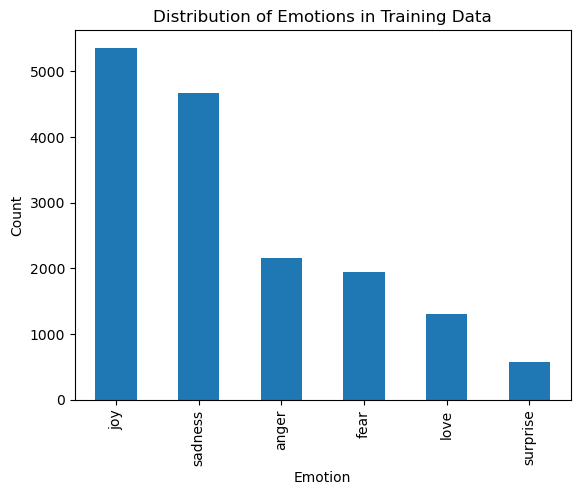

In [52]:
#I created a barplot to check how emotions are distibuted. We can observe that joy and sadness has the 
#biggest count.
label_counts = train['description'].value_counts()
import matplotlib.pyplot as plt

label_counts.plot(kind='bar')
plt.title('Distribution of Emotions in Training Data')
plt.xlabel('Emotion')
plt.ylabel('Count')


Text(0, 0.5, 'Text Length')

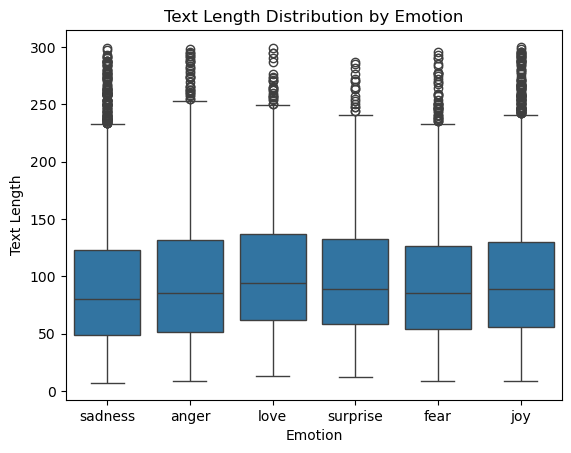

In [53]:
#The comparison of text lengths across emotions shows a uniform distribution without major outliers.
#This means the text lengths are consistent for all emotions. 
#A balanced dataset like this helps prevent bias in model training caused by text size differences.
import seaborn as sns

train['text_length'] = train['text'].apply(len)
sns.boxplot(x=train['description'], y='text_length', data=train)
plt.title('Text Length Distribution by Emotion')
plt.xlabel('Emotion')
plt.ylabel('Text Length')


Now I will create a model capable of distinguishing between 6 emotions. I plan to achieve this by using a CountVectorizer to transform the text data into numerical features, representing the 6 emotion classes

But before diving into deeper analysis I such as identifying the most common words for each emotion or exploring patterns in the dataset, I first tested whether TF-IDFVectorizer would outperform CountVectorizer. The results show that CountVectorizer performs better for this task. This outcome may be influenced by the nature of the dataset. As analyzed earlier, the texts are relatively short and written in an informal style with simpler language. This makes CountVectorizer more effective, as it captures the raw frequency of words without penalizing common terms. Additionally, emotions in this dataset might be better represented by specific phrases or combinations of basic words, which aligns well with the CountVectorizer approach.

In [54]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score



y_train = train['label']
y_val = validation['label']
y_test = test['label']

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(train['text'])
X_val_tfidf = tfidf_vectorizer.transform(validation['text'])
X_test_tfidf = tfidf_vectorizer.transform(test['text'])

model = LogisticRegression()
model.fit(X_train_tfidf, y_train)
y_val_pred = model.predict(X_val_tfidf)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

y_test_pred_tfidf = model.predict(X_test_tfidf)
print(f"TF-IDF Vectorizer Test Accuracy: {accuracy_score(y_test, y_test_pred_tfidf):.2f}")

count_vectorizer = CountVectorizer()
X_train = count_vectorizer.fit_transform(train['text'])
X_val = count_vectorizer.transform(validation['text'])
X_test = count_vectorizer.transform(test['text'])

model = LogisticRegression()
model.fit(X_train, y_train)
y_val_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")
y_test_pred = model.predict(X_test)
print(f"CountVectorizer Test Accuracy: {accuracy_score(y_test, y_test_pred):.2f}")

#Validation accuracy measures the model's performance on unseen data during training,
#helping to tune the model and prevent overfitting. Test accuracy, on the other hand, 
#evaluates the model's ability to generalize to completely new, real-world data, 
#serving as the final measure of performance.



Validation Accuracy: 0.8595
TF-IDF Vectorizer Test Accuracy: 0.86
Validation Accuracy: 0.8890
CountVectorizer Test Accuracy: 0.89


c:\Users\Dell Latitude E5550\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [55]:
#In this 6-class classification problem (emotions: sadness, joy, love, anger, fear, surprise), 
#we aim to analyze which words have the strongest influence on predicting each emotion. 
#By examining the model's coefficients, we can identify the top 10 words for each emotion
#that most significantly contribute to the model's decision-making process.

coefficients = model.coef_
vocabulary = count_vectorizer.get_feature_names_out()

# Iterate through each emotion
for i, emotion in enumerate(labels_dict.values()):
    print(f"\nTop words influencing the emotion '{emotion}':")
    
    emotion_coef = coefficients[i]
    word_coef = list(zip(vocabulary, emotion_coef))
    
    sorted_words = sorted(word_coef, key=lambda x: x[1], reverse=True)
    top_words = sorted_words[:10]
    
    for word, coef in top_words:
        print(f"{word}: {coef:.4f}")



Top words influencing the emotion 'sadness':
lethargic: 3.2387
troubled: 3.2059
unwelcome: 3.1131
melancholy: 3.0847
groggy: 3.0233
punished: 3.0149
awkward: 3.0141
lousy: 3.0099
disturbed: 3.0065
defeated: 2.9901

Top words influencing the emotion 'joy':
innocent: 2.8822
superior: 2.8419
satisfied: 2.7478
resolved: 2.6931
respected: 2.6913
sincere: 2.6876
pleasant: 2.5729
convinced: 2.5668
determined: 2.5497
divine: 2.5396

Top words influencing the emotion 'love':
sympathetic: 4.2993
nostalgic: 4.2363
naughty: 3.9987
longing: 3.9946
horny: 3.9694
fond: 3.9212
delicate: 3.8699
tender: 3.7901
caring: 3.7727
supportive: 3.7211

Top words influencing the emotion 'anger':
greedy: 3.7728
resentful: 3.7449
offended: 3.6559
fucked: 3.6551
irritable: 3.6486
cranky: 3.5471
dangerous: 3.5399
dissatisfied: 3.5363
rebellious: 3.5349
distracted: 3.5174

Top words influencing the emotion 'fear':
pressured: 4.1659
shaken: 3.9700
vulnerable: 3.9329
terrified: 3.9182
reluctant: 3.8743
uncertain: 3.78

In [56]:
#Using the model's predicted probabilities, we identify the text most strongly associated with each emotion.
#For each emotion, we find the text with the highest probability of belonging to that class.
#When we look at 'Most 'sadness' text' there is a sentence with many negative words that are denied. 
#Logistic regression is a linear model that does not consider word relationships or negations ("do not feel").
#Although when I think about it the text might be sarcastic, where the explicit denial of negative 
#emotions is meant to emphasize their presence ironically.

probabilities = model.predict_proba(X)

for i, emotion in enumerate(labels_dict.values()):

    max_index = np.argmax(probabilities[:, i])
    
    most_emotion_text = train['text'].iloc[max_index]
    most_emotion_prob = probabilities[max_index, i]
    
    print(f"\nMost '{emotion}' text:")
    print(f"Text: {most_emotion_text}")
    print(f"Probability: {most_emotion_prob:.4f}")



Most 'sadness' text:
Text: i do not feel unhappy miserable wretched glum gloomy forelorn or heartbroken
Probability: 1.0000

Most 'joy' text:
Text: i feel so cool cool cool cool cool girl i feel so cool cool cool cool cool girl
Probability: 1.0000

Most 'love' text:
Text: i am being selfish but i feel like me trying to make him horny is redundant because he is always horny and i feel like he should try harder to make me horny
Probability: 1.0000

Most 'anger' text:
Text: i feel that we are heading for an abyss that has been created by the greedy the too greedy and the far too greedy
Probability: 1.0000

Most 'fear' text:
Text: i also feel terrified but i ve found that since i ve started saying i m terrified out loud i feel less terrified
Probability: 1.0000

Most 'surprise' text:
Text: i remembered seeing these pieces and feeling so impressed by them but seeing them again i was surprised i was blinded by my memories
Probability: 0.9997
